In [22]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3  # RGB images
BATCH_SIZE = 32

In [3]:
im = df = pd.read_csv('./data/image_metadata.csv', index_col = 0)

In [4]:
for idx, row in tqdm(im.iterrows(), desc='Image processing'):
    path = row['Image Path']
    category = row['SwedeFinal']

    # Load image
    img = PIL.Image.open(path)

    # Resize image
    img = img.resize(IMAGE_SIZE)

    # Create Category dir if not exist
    if not os.path.exists(f'./data/sorted/{category}'):
        os.mkdir(f'./data/sorted/{category}')

    # Save sorted
    img.save(f'./data/sorted/{category}/{os.path.basename(path)}')

Image processing: 909it [00:15, 59.37it/s]


In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory('data/sorted',
                                                   validation_split=0.2,
                                                   subset="training",
                                                   seed=123,
                                                   image_size=IMAGE_SIZE,
                                                   batch_size=BATCH_SIZE)

Found 909 files belonging to 11 classes.
Using 728 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory('data/sorted',
                                                   validation_split=0.2,
                                                   subset="validation",
                                                   seed=123,
                                                   image_size=IMAGE_SIZE,
                                                   batch_size=BATCH_SIZE)

Found 909 files belonging to 11 classes.
Using 181 files for validation.


In [7]:
class_names = train_ds.class_names

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,659 (24.60 MB)

 Trainable params: 6,447,659 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 483ms/step - accuracy: 0.1258 - loss: 2.9054 - val_accuracy: 0.2155 - val_loss: 2.2272
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - accuracy: 0.1854 - loss: 2.2379 - val_accuracy: 0.2541 - val_loss: 2.2377
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.2557 - loss: 2.1959 - val_accuracy: 0.1326 - val_loss: 2.3468
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 474ms/step - accuracy: 0.2892 - loss: 2.0779 - val_accuracy: 0.2155 - val_loss: 2.1364
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - accuracy: 0.3997 - loss: 1.7975 - val_accuracy: 0.2597 - val_loss: 2.2440
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.5600 - loss: 1.3557 - val_accuracy: 0.2762 - val_loss: 2.4708
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.6674 - loss: 0.9036 - val_accuracy: 0.1989 - val_loss: 2.8545
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 475ms/step - accuracy: 0.8652 - loss: 0.5344 - val_accu

In [12]:
test_img_path = "data/B1c.jpg"

img = tf.keras.utils.load_img(
    test_img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
This image most likely belongs to 8 with a 56.51 percent confidence.


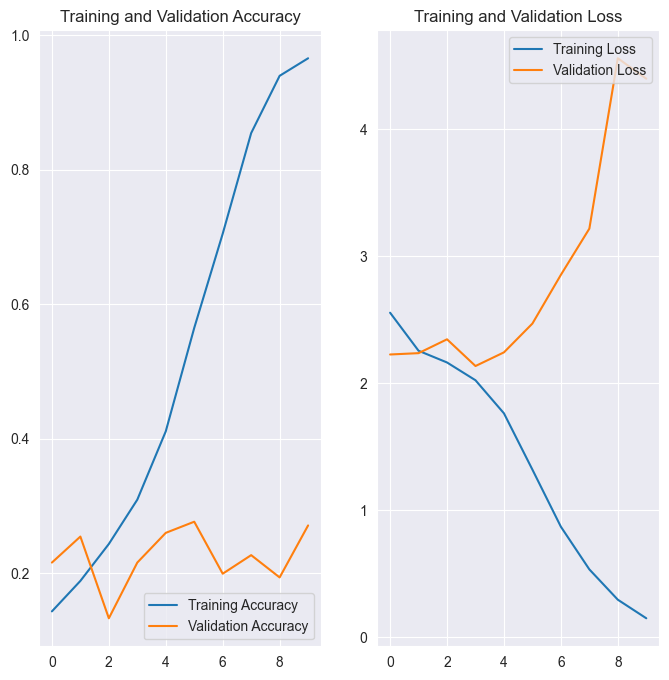

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_HEIGHT,
                                  IMAGE_WIDTH,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/usr/local/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,659 (24.60 MB)

 Trainable params: 6,447,659 (24.60 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 540ms/step - accuracy: 0.1331 - loss: 3.2501 - val_accuracy: 0.1768 - val_loss: 2.2761
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 537ms/step - accuracy: 0.1599 - loss: 2.2556 - val_accuracy: 0.1768 - val_loss: 2.2083
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 549ms/step - accuracy: 0.1799 - loss: 2.2300 - val_accuracy: 0.1823 - val_loss: 2.2162
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 530ms/step - accuracy: 0.2078 - loss: 2.1950 - val_accuracy: 0.1989 - val_loss: 2.1999
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.1967 - loss: 2.2095 - val_accuracy: 0.2541 - val_loss: 2.1611
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 546ms/step - accuracy: 0.2183 - loss: 2.1679 - val_accuracy: 0.1878 - val_loss: 2.1890
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 579ms/step - accuracy: 0.2343 - loss: 2.1635 - val_accuracy: 0.2597 - val_loss: 2.1362
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.2358 - loss: 2.1564 - val_accu

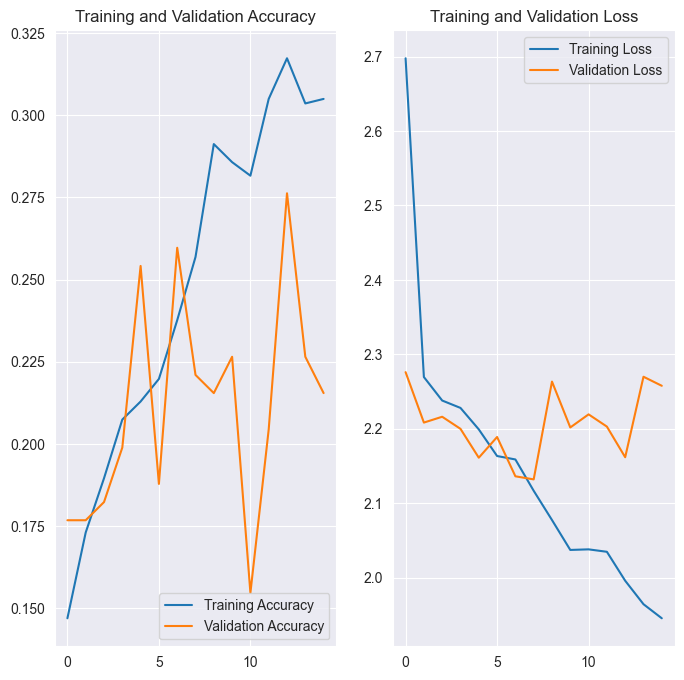

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
test_img_path = "data/B1c.jpg"

img = tf.keras.utils.load_img(
    test_img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
This image most likely belongs to 8 with a 29.79 percent confidence.
